In [1]:
import numpy as np
import sympy as sp
import wlcstat.wlc_copoly as wlc_copoly
from scipy.interpolate import interp1d

#FOR VERTEX:
import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

sp.var("DEL_A1 DEL_B1 DEL_A2")
DEL_B2 = -DEL_A1 -DEL_B1 -DEL_A2

# Functions
From the overleaf document "Polydisperse Polymer Field Theory- no averaging" we found that the free energy of a polydisperse system can be broken down into a sum of the contributions from each polymer type, but with $2*n_{poly}$ polymer field fluctutaion terms. This indicates that the free energy calculation procedure for a monodipserse system is highly relevant. 

These binary mix functions were adapted from Vertex codebase by Quinn\Shifan. These functions were for a monodisperse system, where the incompressibility condition $\Delta_A = - \Delta_B$. In the finctions themselves this manifests as multiplying by a negative at certain points in the einstein sum. 
//

For applications to polydisperse systems, this incompressiblity condition does not hold. Therefore, we must first undo this simple, monodisperse incompressiblity condition (apply additional negatives to counteract the condition), then multiply by an array of density fluctutations "dlta" which applies the correct incompressibility condition (the last entry is the negative sum of all previous entries, such that the sum of all entries = 0). 

In [3]:
def gamma2binary(pset, K, poly_list, dlta, CHI):
    G = 0
    for i, poly in enumerate(poly_list):
        FA = poly[0]
        N = poly[1]
        phi_poly = poly[2]
        
        s2inv = s2inverse(pset, N, FA, K)
        for I0, I1 in product([0,1], repeat=2):
            G += (1/phi_poly)*N*s2inv[I0, I1]* dlta[I0+i*2]*dlta[I1+i*2]  #removed sign indicator -> pre-incompressible
        
    G += 2*CHI*(dlta[0]*dlta[1] + dlta[0]*dlta[3] + dlta[2]*dlta[1] + dlta[2]*dlta[3]) # hardcoded for binary

    return G

In [4]:
def gamma3binary(pset, Ks, poly_list, dlta):
    #Assuming same N
    #hardcoded DELTA
    #need to return an obe=ejc tthat has 3 different amplitude variables which can be minimized over in scipy
    
    K1, K2, K3 = Ks
    if norm(K1+K2+K3) >= 1e-10:
        raise('Qs must add up to zero')
        
    if not (abs(norm(K1)-norm(K2)) < 1e-5 \
        and abs(norm(K2)-norm(K3)) < 1e-5):
        raise('Qs must have same length')
        
    val = 0
    for i, poly in enumerate(poly_list):
        FA = poly[0]
        N = poly[1]
        phi_poly = poly[2]
        
        s3 = s3wlc(pset, N, FA, Ks)
        s2inv = s2inverse(pset, N, FA, norm(K1))
        for I0, I1, I2 in product([0,1], repeat=3):
            val -= (phi_poly) * s3[I0][I1][I2]* (s2inv[I0][0] - s2inv[I0][1])*\
                                   (s2inv[I1][0] - s2inv[I1][1])*\
                                   (s2inv[I2][0] - s2inv[I2][1])*\
                                    ((-1)**(I0 + I1 + I2))*\
                                    dlta[I0+i*2]*dlta[I1+i*2]*dlta[I2+i*2] 

    return val*(N**2) 

In [5]:
def gamma4binary(pset, wigset, Ks, poly_list, dlta):
    #Assuming same N
    #hardcoded DELTA
    #need to return an obe=ejc tthat has 3 different amplitude variables which can be minimized over in scipy
    K1, K2, K3, K4 = Ks
    if not (abs(norm(K1)-norm(K2)) < 1e-5
            and abs(norm(K2)-norm(K3)) < 1e-5
            and abs(norm(K3)-norm(K4)) < 1e-5):
        print(K1, K2, K3, K4)
        raise('Qs must have same length')
    
    K = norm(K1)
    K12 = norm(K1+K2)
    K13 = norm(K1+K3)
    K14 = norm(K1+K4)
    
    val = 0
    for i, poly in enumerate(poly_list):
        FA = poly[0]
        N = poly[1]
        phi_poly = poly[2]
    
        s4 = s4wlc(pset, wigset, N, FA, Ks)
        s31 = s3wlc(pset, N, FA, [K1, K2, -K1-K2])
        s32 = s3wlc(pset, N, FA, [K1, K3, -K1-K3])
        s33 = s3wlc(pset, N, FA, [K1, K4, -K1-K4])

        s2inv = s2inverse(pset, N, FA, K)
        s21inv = s2inverse(pset, N, FA, K12)
        s22inv = s2inverse(pset, N, FA, K13)
        s23inv = s2inverse(pset, N, FA, K14)

        G4 = np.zeros((2,2,2,2),dtype=type(1+1j))
        for a1, a2, a3, a4 in product([0,1], repeat=4):
            for I0, I1 in product([0,1], repeat=2):
                G4[a1][a2][a3][a4] += \
                    s31[a1][a2][I0]*s31[a3][a4][I1]*s21inv[I0][I1] + \
                    s32[a1][a4][I0]*s32[a2][a3][I1]*s22inv[I0][I1] + \
                    s33[a1][a3][I0]*s33[a2][a4][I1]*s23inv[I0][I1]
        G4 -= s4

    #     val = 0
        for I0, I1, I2, I3 in product([0,1], repeat=4):
            val += (phi_poly)*G4[I0][I1][I2][I3] *\
                    (s2inv[I0][0] - s2inv[I0][1])*\
                    (s2inv[I1][0] - s2inv[I1][1])*\
                    (s2inv[I2][0] - s2inv[I2][1])*\
                    (s2inv[I3][0] - s2inv[I3][1])*\
                    (-1)**(I0 + I1 + I2 + I3)*\
                    dlta[I0+i*2]*dlta[I1+i*2]*dlta[I2+i*2]*dlta[I3+i*2]  

    return val*(N**3)

# Phase diagram comparisons

In [71]:
N_1 = 10.
FA_1_arr = np.arange(0.3, 0.701, .1) #np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, .5, 0.6, 0.7, 0.8]) #np.arange(0.1, 0.701, 0.05) #np.array([0.01, 0.02, 0.05, 0.1, 0.3, .5, 0.7])#
FA_1 = 0.5
PHI_1 = 0.99999

N_2 = N_1
FA_2 = 0.9
PHI_2 = 0.00001

if (PHI_1 + PHI_2 > 1.00001) or (PHI_1 + PHI_2 < 1 - .00001):
    raise Exception("Phis dont add up to 1")

chi_array = np.arange(7.5, 15, 0.1)/N_1

## Free energy calculation

### Monodisperse (Vertex codebase)

In [ ]:
%%time
#SINGLE WAVEMODE PHASE DIAGRAM
N = N_1
fa_array = FA_1_arr

cyl_pnts_vert = np.array([])
lam_pnts_vert = np.array([])
dis_pnts_vert = np.array([])

for FA in fa_array:
    KS = spinodal(pset, N, FA)
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    lam_g3 = 0
    
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N, FA, cyl_qs)
    
    lam_g4 = (1/24) * (6) * (1) * gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    
    cyl_g4 = (1/12)* (gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
       
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1) * gamma2(pset, N, FA, q_star, CHI)                
        
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2(pset, N, FA, q_star, CHI) 
        
        amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
                              1, disp=False)
        amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
                              1, disp=False)
        
        lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
        
        cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
             
        point = np.array([FA, CHI*N])
        
        if (lamF > 0 and cylF > 0):
            #disordered stable
            dis_pnts_vert = np.append(dis_pnts_vert, point)
        elif (lamF < cylF):
            lam_pnts_vert = np.append(lam_pnts_vert, point) 
        else:
            cyl_pnts_vert = np.append(cyl_pnts_vert, point)

            
    print("one FA done!!")
            

### Polydisperse

In [73]:
%%time
cyl_pnts_poly = np.array([])
lam_pnts_poly = np.array([])
dis_pnts_poly = np.array([])

dlta = np.array([DEL_A1, DEL_B1, DEL_A2, DEL_B2])

for FA_1 in FA_1_arr:
    poly_list = [[FA_1, N_1, PHI_1], [FA_2, N_2, PHI_2]]
    KS = spinodal(pset, N_1, FA_1) #TODO: WRONG b/c based on monodisperse gamma2 result .need to redo for polydisp
    q_star = KS[0]

    lam_q = q_star*np.array([1, 0, 0])

    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])  
    
    
    G3_poly_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3binary(pset, cyl_qs, poly_list, dlta)

    G3_poly_lam = 0
    
    G3lambd_cyl = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G3_poly_cyl, 'numpy')

    
    G4p_lam = (1/24) * (6) *gamma4binary(pset, wigset, np.array([lam_q, -lam_q, lam_q, -lam_q]), poly_list, dlta)

    G4p_cyl = (1/12) * (gamma4binary(pset, wigset, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), poly_list, dlta) + \
              4*gamma4binary(pset, wigset, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), poly_list, dlta))

    G4lambd_cyl = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G4p_cyl, 'numpy')

    G4lambd_lam = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G4p_lam, 'numpy')
    
    for CHI in chi_array:
        
        G2poly = gamma2binary(pset, k_vec, poly_list, dlta, CHI)

        G2lambd = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G2poly, 'numpy')
        
        # amp = optimize.fmin(lambda amp: G3lambd(amp[0], amp[1], amp[2]), [1,1,1], disp=False)

        amp_poly_cyl = optimize.fmin(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2])+ G3lambd_cyl(amps[0], amps[1], amps[2])\
                                                          + G4lambd_cyl(amps[0], amps[1], amps[2])), [1,1,1], disp=False)

        amp_poly_lam = optimize.fmin(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2])\
                                                          + G4lambd_lam(amps[0], amps[1], amps[2])), [1,1,1], disp=False)


        polyF_cyl = G2lambd(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])+ G3lambd_cyl(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])\
                                                      + G4lambd_cyl(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])

        polyF_lam = G2lambd(amp_poly_lam[0], amp_poly_lam[1], amp_poly_lam[2])+ G4lambd_lam(amp_poly_lam[0], amp_poly_lam[1], amp_poly_lam[2])

        point = np.array([FA_1, CHI*N_1])

        if (lamF > 0 and cylF > 0):
            #disordered stable
            dis_pnts = np.append(dis_pnts, point)
        elif (lamF < cylF):
            lam_pnts = np.append(lam_pnts, point) 
        else:
            cyl_pnts = np.append(cyl_pnts, point)
            
    print("one FA done!")

NameError: name 'N' is not defined

## Generate interpolation functions

In [66]:
#generate interpolation functions
phase_list = np.array([dis_pnts, lam_pnts, cyl_pnts])

# max_min_dis_pnts = np.array([])
# max_min_lam_pnts = np.array([])
# max_min_cyl_pnts = np.array([])
# max_min_gyr_pnts = np.array([])
# max_min_sq_cyl_pnts = np.array([])

max_dis_pnts = np.array([])
min_dis_pnts = np.array([])
max_lam_pnts = np.array([])
min_lam_pnts = np.array([])
max_cyl_pnts = np.array([])
min_cyl_pnts = np.array([])

for i, phse in enumerate(phase_list):
    phse_x = phse[::2]
    phse_y = phse[1::2]
    
    new_phase_pnt_arr_maxs = np.array([])
    new_phase_pnt_arr_mins = np.array([])

    for fa_val in fa_array:
        min_pnt = []
        max_pnt = []
        same_fa_y_vals = np.array([])
        for j, phx in enumerate(phse_x):
            
            if phx == fa_val:
#                 print("allowed fa", fa_val)
                same_fa_y_vals = np.append(same_fa_y_vals, phse_y[j])
        
        if len(same_fa_y_vals) != 0:
            min_pnt = [fa_val, min(same_fa_y_vals)]
            max_pnt = [fa_val, max(same_fa_y_vals)]
        
        new_phase_pnt_arr_mins = np.append(new_phase_pnt_arr_mins, min_pnt)
        new_phase_pnt_arr_maxs = np.append(new_phase_pnt_arr_maxs, max_pnt)
    
    
    if i == 0:
        max_dis_pnts = new_phase_pnt_arr_maxs
        min_dis_pnts = new_phase_pnt_arr_mins
    elif i == 1:
        max_lam_pnts = new_phase_pnt_arr_maxs
        min_lam_pnts = new_phase_pnt_arr_mins
    elif i == 2:
        max_cyl_pnts = new_phase_pnt_arr_maxs
        min_cyl_pnts = new_phase_pnt_arr_mins
    elif i == 3:
        max_min_gyr_pnts = np.append(new_phase_pnt_arr_mins, new_phase_pnt_arr_maxs)
    elif i == 4:
        max_sq_cyl_pnts = new_phase_pnt_arr_maxs
        min_sq_cyl_pnts = new_phase_pnt_arr_mins
    




    #get array of all XNs at that fa
    #find max an min
    #return those two points
    #get all x values
    #for all fas, see if present for each phase.
    #if multple ponts in one fa for one phase, find min and max XN points

## Plot

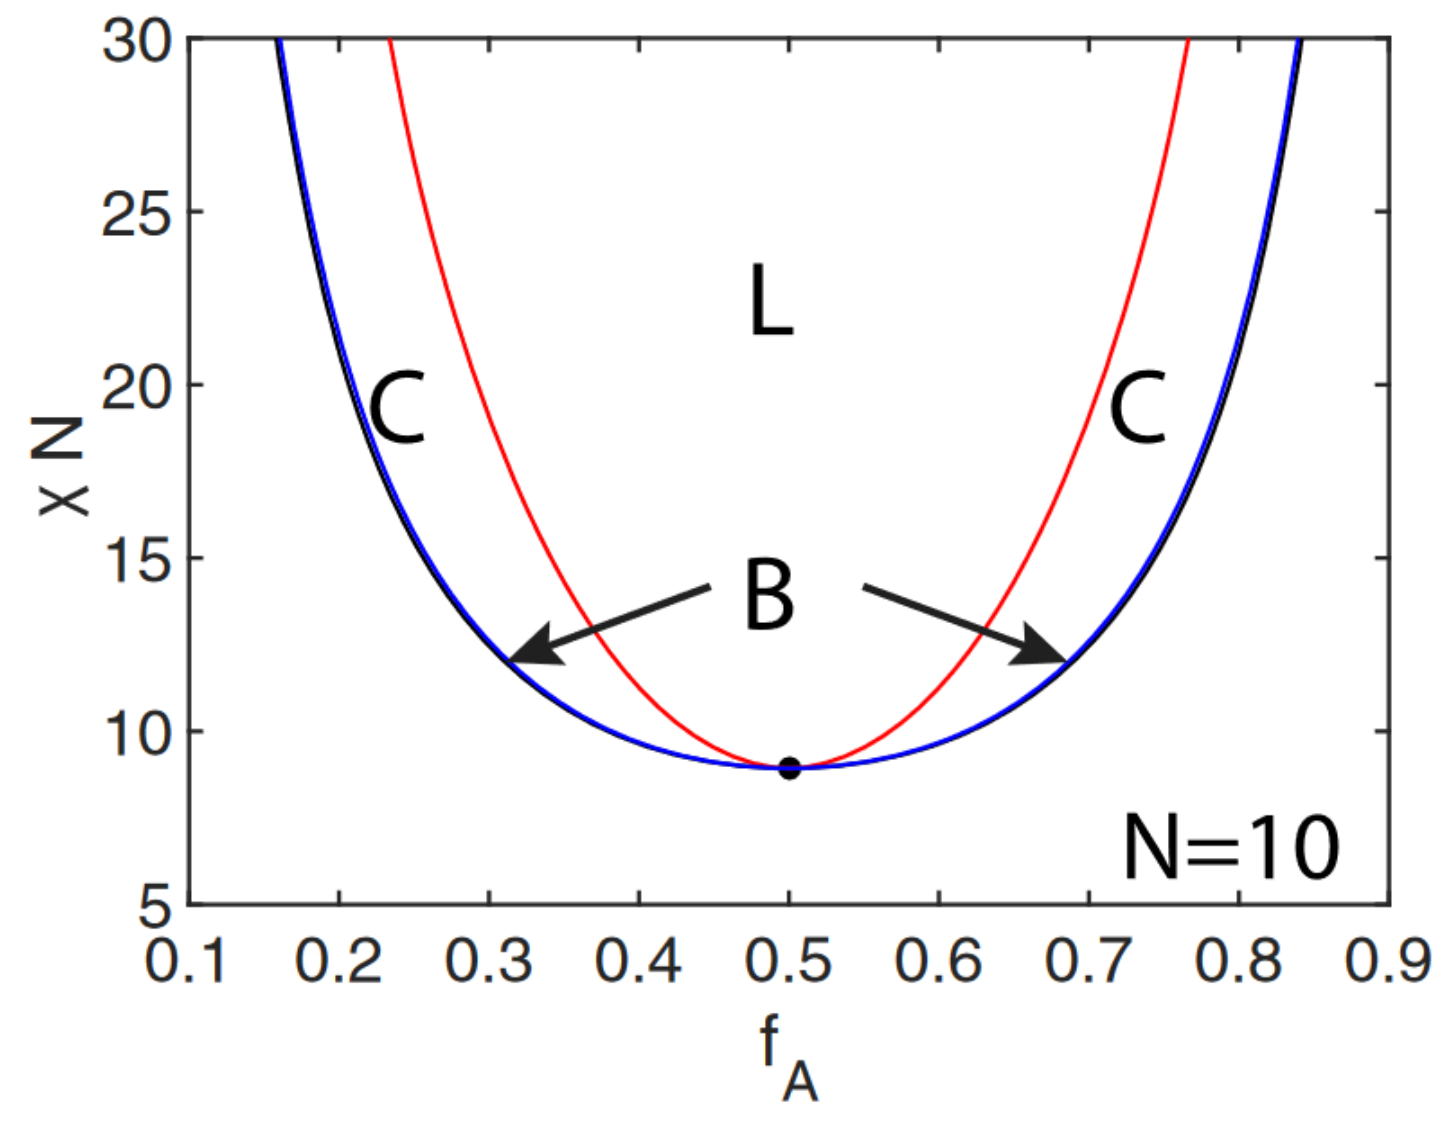

## Single-point free energy calculations

In [66]:
N_1 = 10.
# FA_1_arr = np.arange(0.3, 0.701, .1) #np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, .5, 0.6, 0.7, 0.8]) #np.arange(0.1, 0.701, 0.05) #np.array([0.01, 0.02, 0.05, 0.1, 0.3, .5, 0.7])#
FA_1 = 0.5
PHI_1 = 0.99999

N_2 = N_1
FA_2 = 0.9
PHI_2 = 0.00001

poly_list = [[FA_1, N_1, PHI_1], [FA_2, N_2, PHI_2]]
dlta = np.array([DEL_A1, DEL_B1, DEL_A2, DEL_B2])

KS = spinodal(pset, N_1, FA_1) #TODO: WRONG b/c based on monodisperse gamma2 result .need to redo for polydisp
q_star = KS[0]

k_vec = KS
k_ind = 0

lam_q = q_star*np.array([1, 0, 0])

cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

CHI = 15/N_1

monodisp_FA_arr = np.arange(0.3, 0.701, 0.1)

if (PHI_1 + PHI_2 > 1.00001) or (PHI_1 + PHI_2 < 1 - .00001):
    raise Exception("Phis dont add up to 1")

In [67]:
G2poly = gamma2binary(pset, k_vec, poly_list, dlta, CHI)


G3_poly_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3binary(pset, cyl_qs, poly_list, dlta)

G3_poly_lam = 0


G4p_lam = (1/24) * (6) *gamma4binary(pset, wigset, np.array([lam_q, -lam_q, lam_q, -lam_q]), poly_list, dlta)

G4p_cyl = (1/12) * (gamma4binary(pset, wigset, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), poly_list, dlta) + \
          4*gamma4binary(pset, wigset, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), poly_list, dlta))


G2lambd = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G2poly, 'numpy')

G3lambd_cyl = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G3_poly_cyl, 'numpy')

G4lambd_cyl = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G4p_cyl, 'numpy')

G4lambd_lam = sp.lambdify([DEL_A1, DEL_B1, DEL_A2], G4p_lam, 'numpy')

In [68]:
# amp = optimize.fmin(lambda amp: G3lambd(amp[0], amp[1], amp[2]), [1,1,1], disp=False)

amp_poly_cyl = optimize.fmin(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2])+ G3lambd_cyl(amps[0], amps[1], amps[2])\
                                                  + G4lambd_cyl(amps[0], amps[1], amps[2])), [1,1,1], disp=False)

amp_poly_lam = optimize.fmin(lambda amps: np.real(G2lambd(amps[0], amps[1], amps[2])\
                                                  + G4lambd_lam(amps[0], amps[1], amps[2])), [1,1,1], disp=False)


polyF_cyl = G2lambd(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])+ G3lambd_cyl(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])\
                                              + G4lambd_cyl(amp_poly_cyl[0], amp_poly_cyl[1], amp_poly_cyl[2])

polyF_lam = G2lambd(amp_poly_lam[0], amp_poly_lam[1], amp_poly_lam[2])+ G4lambd_lam(amp_poly_lam[0], amp_poly_lam[1], amp_poly_lam[2])

In [69]:
polyF_cyl

(-0.057331611273124444-3.7286023609842296e-16j)

In [70]:
polyF_lam

(-0.0989904633960465-7.268100263832286e-16j)

### Re-applying incompressibility test on a Monodisperse system

The goal here is to undo incompressibility in base Vertex functions (appliying -1s correctly), then re-apply it with a delta array that has the condition applied, ALL FOR A MONODISPERSE SYSTEM. Should get exact same results as original Vertex codebase.

In [35]:
#check if approach works for monodisperse

#for each func, need to remove incompressiblity condition and add dels which enforce incompressibilty
def gamma2_M(pset, N, FA, K, CHI, dlta):
    s2inv = s2inverse(pset, N, FA, K)

#     D = [1,-1]    # sign indicator
    G = 0
    for I0, I1 in product([0,1], repeat=2):
        G += N*s2inv[I0, I1]*dlta[I0]*dlta[I1] #removed sign indicator
    
    G += 2*CHI*(dlta[0]*dlta[1])
    return G#-2*CHI + N*G

def gamma3_M(pset, N, FA, Ks, dlta):
    K1, K2, K3 = Ks
    if norm(K1+K2+K3) >= 1e-10:
        raise('Qs must add up to zero')
        
    if not (abs(norm(K1)-norm(K2)) < 1e-5 \
        and abs(norm(K2)-norm(K3)) < 1e-5):
        raise('Qs must have same length')
    
    s3 = s3wlc(pset, N, FA, Ks)
    s2inv = s2inverse(pset, N, FA, norm(K1))
    
    val = 0
    for I0, I1, I2 in product([0,1], repeat=3):
        #should always be positive del cubed
#         print("---------")
#         print("I0 = " + str(I0) + " I1 = " + str(I1) + " I2 = " + str(I2))
#         print("delta1 = " + str(dlta[I0]) + "delta1 = " + str(dlta[I1]) + "delta1 = " + str(dlta[I2]))
#         print(((-1)**(I0 + I1 + I2))*dlta[I0]*dlta[I1]*dlta[I2])
        val -= s3[I0][I1][I2]* (s2inv[I0][0] - s2inv[I0][1])*\
                               (s2inv[I1][0] - s2inv[I1][1])*\
                               (s2inv[I2][0] - s2inv[I2][1])*\
                                    ((-1)**(I0 + I1 + I2))*\
                                    dlta[I0]*dlta[I1]*dlta[I2] 

    return val*(N**2)

def gamma4_M(pset, wigset, N, FA, Ks, dlta):
    K1, K2, K3, K4 = Ks
    if not (abs(norm(K1)-norm(K2)) < 1e-5
            and abs(norm(K2)-norm(K3)) < 1e-5
            and abs(norm(K3)-norm(K4)) < 1e-5):
        print(K1, K2, K3, K4)
        raise('Qs must have same length')
    
    K = norm(K1)
    K12 = norm(K1+K2)
    K13 = norm(K1+K3)
    K14 = norm(K1+K4)
    
    s4 = s4wlc(pset, wigset, N, FA, Ks)
    s31 = s3wlc(pset, N, FA, [K1, K2, -K1-K2])
    s32 = s3wlc(pset, N, FA, [K1, K3, -K1-K3])
    s33 = s3wlc(pset, N, FA, [K1, K4, -K1-K4])

    s2inv = s2inverse(pset, N, FA, K)
    s21inv = s2inverse(pset, N, FA, K12)
    s22inv = s2inverse(pset, N, FA, K13)
    s23inv = s2inverse(pset, N, FA, K14)

    G4 = np.zeros((2,2,2,2),dtype=type(1+1j))
    for a1, a2, a3, a4 in product([0,1], repeat=4):
        for I0, I1 in product([0,1], repeat=2):
            G4[a1][a2][a3][a4] += \
                s31[a1][a2][I0]*s31[a3][a4][I1]*s21inv[I0][I1] + \
                s32[a1][a4][I0]*s32[a2][a3][I1]*s22inv[I0][I1] + \
                s33[a1][a3][I0]*s33[a2][a4][I1]*s23inv[I0][I1]
    G4 -= s4
    
    val = 0
    for I0, I1, I2, I3 in product([0,1], repeat=4):
        val += G4[I0][I1][I2][I3] *\
                (s2inv[I0][0] - s2inv[I0][1])*\
                (s2inv[I1][0] - s2inv[I1][1])*\
                (s2inv[I2][0] - s2inv[I2][1])*\
                (s2inv[I3][0] - s2inv[I3][1])*\
                ((-1)**(I0 + I1 + I2 + I3))*\
                dlta[I0]*dlta[I1]*dlta[I2]*dlta[I3]  
                
    return val*(N**3)

In [52]:
N_1 = 10.
# FA_1_arr = p.arange(0.3, 0.701, .1) #np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, .5, 0.6, 0.7, 0.8]) #np.arange(0.1, 0.701, 0.05) #np.array([0.01, 0.02, 0.05, 0.1, 0.3, .5, 0.7])#
FA_1 = 0.3

dlta = np.array([DEL_A1, DEL_B1, DEL_A2, DEL_B2])

KS = spinodal(pset, N_1, FA_1) #TODO: WRONG b/c based on monodisperse gamma2 result .need to redo for polydisp
q_star = KS[0]

k_vec = KS
k_ind = 0

lam_q = q_star*np.array([1, 0, 0])

cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

CHI = 25/N_1

In [53]:
delta_mono = [DEL_A1, -1 * DEL_A1]

In [54]:
G2mono = gamma2_M(pset, N_1, FA_1, k_vec, CHI, delta_mono)


G3_mono_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_M(pset, N_1, FA_1, cyl_qs, delta_mono)

G3_mono_lam = 0


G4m_lam = (1/24) * (6) *gamma4_M(pset, wigset, N_1, FA_1, np.array([lam_q, -lam_q, lam_q, -lam_q]), delta_mono)

G4m_cyl = (1/12) * (gamma4_M(pset, wigset, N_1, FA_1, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), delta_mono) + \
          4*gamma4_M(pset, wigset, N_1, FA_1, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), delta_mono))


G2lambd_M = sp.lambdify([DEL_A1], G2mono, 'numpy')

G3lambd_cyl_M = sp.lambdify([DEL_A1], G3_mono_cyl, 'numpy')

G4lambd_cyl_M = sp.lambdify([DEL_A1], G4m_cyl, 'numpy')

G4lambd_lam_M = sp.lambdify([DEL_A1], G4m_lam, 'numpy')

In [55]:
# amp = optimize.fmin(lambda amp: G3lambd(amp[0], amp[1], amp[2]), [1,1,1], disp=False)

amp_cyl = optimize.fmin(lambda amps: np.real(G2lambd_M(amps)+ G3lambd_cyl_M(amps) + G4lambd_cyl_M(amps)), 1, disp=False)

amp_lam = optimize.fmin(lambda amps: np.real(G2lambd_M(amps[0]) + G4lambd_lam_M(amps[0])), [1], disp=False)


mine_monoF_cyl = G2lambd_M(amp_cyl[0]) + G3lambd_cyl_M(amp_cyl[0]) + G4lambd_cyl_M(amp_cyl[0])

mine_monoF_lam = G2lambd_M(amp_lam[0]) + G4lambd_lam_M(amp_lam[0])

In [58]:
%%time
#single component G2 matrix stability analysis, POST INCOMPRESSIBILITY 

G2vert = gamma2(pset, N_1, FA_1, q_star, CHI)

G3vert_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N_1, FA_1, cyl_qs) 
G4vert_cyl = (1/12)* (gamma4(pset, wigset, N_1, FA_1, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
          4*gamma4(pset, wigset, N_1, FA_1, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))

G3vert_lam = 0
G4vert_lam = (1/24) * (6) * (1) * gamma4(pset, wigset, N_1, FA_1, np.array([lam_q, -lam_q, lam_q, -lam_q]))

amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * G2vert + amps**3 * G3vert_cyl + amps**4 * G4vert_cyl), \
                      1, disp=False)

amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * G2vert + amps**3 * G3vert_lam + amps**4 * G4vert_lam), \
                      1, disp=False)

vert_cylF = amp_c1**2 * G2vert + amp_c1**3 * G3vert_cyl + amp_c1**4 * G4vert_cyl

vert_lamF = amp_l1**2 * G2vert + amp_l1**3 * G3vert_lam + amp_l1**4 * G4vert_lam

Wall time: 1min 46s


In [59]:
vert_cylF

array([-0.12135779-6.4205317e-16j])

In [60]:
vert_lamF

array([-0.1406322-7.6964202e-16j])

In [56]:
mine_monoF_lam

(-0.1406322001346056-7.696420202024692e-16j)

In [57]:
mine_monoF_cyl

(-0.12135779090173807-6.420531695215076e-16j)

In [18]:
# amp = optimize.fmin(lambda amp: G3lambd(amp[0], amp[1], amp[2]), [1,1,1], disp=False)

G2mono = gamma2_M(pset, N_1, FA_1, k_vec, CHI, delta_mono)
G2lambd_M = sp.lambdify([DEL_A1], G2mono, 'numpy')

G3_mono_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3_M(pset, N_1, FA_1, cyl_qs, delta_mono)
G3lambd_cyl_M = sp.lambdify([DEL_A1], G3_mono_cyl, 'numpy')

amp_mine = optimize.fmin(lambda amps: np.real(G2lambd_M(amps) + G3lambd_cyl_M(amps)), 1, disp=False)
monoF_mine = G2lambd_M(amp_mine) + G3lambd_cyl_M(amp_mine)

In [19]:
G2vert = gamma2(pset, N_1, FA_1, k_vec, CHI)
G3vert_cyl = (1/6) * (1/(3*np.sqrt(3))) * 12 * gamma3(pset, N_1, FA_1, cyl_qs)

amp_vert = optimize.fmin(lambda amp: np.real(amp**2 * G2vert + amp**3 * G3vert_cyl), 1, disp=False)
Fvert = amp_vert**2 * G2vert + amp_vert**3 * G3vert_cyl

In [20]:
Fvert

array([-4.62308083e+86+5.10497158e+71j])

In [21]:
monoF_mine

array([-4.62308083e+86+5.10497158e+71j])

In [22]:
G3quinn = gamma3(pset, N_1, FA_1, cyl_qs)

In [23]:
G3quinn

(4.717095413295912-5.208785851992365e-15j)

In [24]:
(-1)**0

1

In [25]:
G3mebaby = gamma3_M(pset, N_1, FA_1, cyl_qs, delta_mono)

In [26]:
sp.simplify(G3mebaby)

DEL_A1**3*(4.71709541329591 - 5.20878585199237e-15*I)

In [27]:
#G2 matches exactly!!
#test g3, g4
21.308914/4.7170954

4.5173803353648525